In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import cv2
import random
import os
import keras
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Dropout,
    GlobalAveragePooling2D,
)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError

# Cấu hình dữ liệu và các hằng số
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
base_path = "/content/gdrive/MyDrive/VND_Dataset"

# Các lớp trong dataset
categories = {
    0: "000000",
    1: "000200",
    2: "000500",
    3: "001000",
    4: "002000",
    5: "005000",
    6: "010000",
    7: "020000",
    8: "050000",
    9: "100000",
    10: "200000",
    11: "500000",
}

def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError) as e:
        print(f'Invalid image file: {file_path} - {e}')
        return False

# Đọc dữ liệu và chuẩn bị DataFrame
filenames_list = []
categories_list = []
for category in categories:
    category_path = os.path.join(base_path, categories[category])
    filenames = os.listdir(category_path)
    valid_filenames = [f for f in filenames if is_valid_image(os.path.join(category_path, f))]
    valid_filenames = [os.path.join(categories[category], f) for f in valid_filenames]
    filenames_list.extend(valid_filenames)
    categories_list.extend([category] * len(valid_filenames))

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})

# Shuffle và split dữ liệu
df = df.sample(frac=1).reset_index(drop=True)
df["category"] = df["category"].replace(categories)

train_df, validate_df = train_test_split(df, test_size=0.25, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

batch_size = 32

# Định nghĩa ImageDataGenerator với các kỹ thuật tăng cường ảnh
datagen = ImageDataGenerator(
    rotation_range=60,       # Xoay ảnh trong khoảng [-60, 60] độ
    width_shift_range=0.2,   # Dịch chuyển ngang ảnh trong khoảng [-20%, 20%]
    height_shift_range=0.2,  # Dịch chuyển dọc ảnh trong khoảng [-20%, 20%]
    shear_range=0.2,         # Biến đổi shear trong khoảng [-20%, 20%]
    zoom_range=0.2,          # Phóng to/thu nhỏ ảnh trong khoảng [-20%, 20%]
    horizontal_flip=True,    # Lật ngang ảnh
    fill_mode='nearest'      # Cách điền giá trị cho các điểm bị mất sau khi biến đổi
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="categorical",
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
)

# Định nghĩa mô hình giáo viên
teacher_model = Sequential()
teacher_model.add(
    Conv2D(
        filters=64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    )
)
teacher_model.add(BatchNormalization())
teacher_model.add(MaxPooling2D(pool_size=(2, 2)))

teacher_model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
teacher_model.add(BatchNormalization())
teacher_model.add(MaxPooling2D(pool_size=(2, 2)))
teacher_model.add(Dropout(0.25))

teacher_model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
teacher_model.add(BatchNormalization())
teacher_model.add(MaxPooling2D(pool_size=(2, 2)))
teacher_model.add(Dropout(0.25))

teacher_model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
teacher_model.add(BatchNormalization())
teacher_model.add(MaxPooling2D(pool_size=(2, 2)))
teacher_model.add(Dropout(0.25))

teacher_model.add(Conv2D(filters=1024, kernel_size=3, padding="same", activation="relu"))
teacher_model.add(BatchNormalization())
teacher_model.add(MaxPooling2D(pool_size=(2, 2)))
teacher_model.add(Dropout(0.25))

teacher_model.add(Flatten())
teacher_model.add(Dense(4096, activation="relu"))
teacher_model.add(BatchNormalization())
teacher_model.add(Dropout(0.5))
teacher_model.add(Dense(len(categories), activation="softmax"))

teacher_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
teacher_model.summary()



Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1006.png - [Errno 2] No such file or directory: '/content/gdrive/MyDrive/VND_Dataset/000000/000000_1006.png'
Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1002.png - [Errno 2] No such file or directory: '/content/gdrive/MyDrive/VND_Dataset/000000/000000_1002.png'
Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1008.png - [Errno 2] No such file or directory: '/content/gdrive/MyDrive/VND_Dataset/000000/000000_1008.png'
Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1007.png - [Errno 2] No such file or directory: '/content/gdrive/MyDrive/VND_Dataset/000000/000000_1007.png'
Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1005.png - [Errno 2] No such file or directory: '/content/gdrive/MyDrive/VND_Dataset/000000/000000_1005.png'
Invalid image file: /content/gdrive/MyDrive/VND_Dataset/000000/000000_1009.png - [Errno 2] No such file o

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 1024)          │              

 Total params: 73,457,036 (280.22 MB)

 Trainable params: 73,444,876 (280.17 MB)

 Non-trainable params: 12,160 (47.50 KB)

In [ ]:
# Hiển thị kích thước của các tập dữ liệu
print(f"Kích thước tập huấn luyện: {train_df.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra: {validate_df.shape[0]} mẫu")
print(f"Kích thước tập thử nghiệm: {test_df.shape[0]} mẫu")

Kích thước tập huấn luyện: 7261 mẫu
Kích thước tập kiểm tra: 1210 mẫu
Kích thước tập thử nghiệm: 1211 mẫu


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 98s 345ms/step - accuracy: 0.3387 - loss: 2.9284 - val_accuracy: 0.1959 - val_loss: 7.5084 - learning_rate: 0.0010
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 244ms/step - accuracy: 0.6052 - loss: 1.5550 - val_accuracy: 0.2248 - val_loss: 3.5302 - learning_rate: 0.0010
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - accuracy: 0.7099 - loss: 1.0306 - val_accuracy: 0.3777 - val_loss: 3.1524 - learning_rate: 0.0010
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - accuracy: 0.7803 - loss: 0.8151 - val_accuracy: 0.3769 - val_loss: 2.9152 - learning_rate: 0.0010
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.8275 - loss: 0.6391 - val_accuracy: 0.5901 - val_loss: 1.5962 - learning_rate: 0.0010
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.8321 - loss: 0.7002 - val_accuracy: 0.2843 - val_loss: 7.2712 - learning_rate: 0.0010
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.8623 -

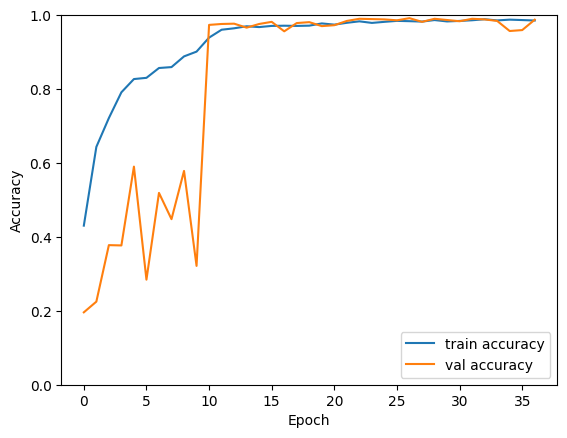

1211/1211 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Classification Report - Teacher Model:
              precision    recall  f1-score   support

      000000       0.99      0.99      0.99       141
      000200       0.97      0.95      0.96        41
      000500       0.94      1.00      0.97        31
      001000       0.93      0.96      0.95        28
      002000       0.96      0.93      0.94        27
      005000       1.00      0.96      0.98        23
      010000       0.97      0.98      0.98       148
      020000       0.99      1.00      0.99       143
      050000       0.97      1.00      0.99       144
      100000       1.00      0.97      0.99       153
      200000       1.00      0.98      0.99       168
      500000       1.00      0.99      1.00       164

    accuracy                           0.99      1211
   macro avg       0.98      0.98      0.98      1211
weighted avg       0.99      0.99      0.99      1211



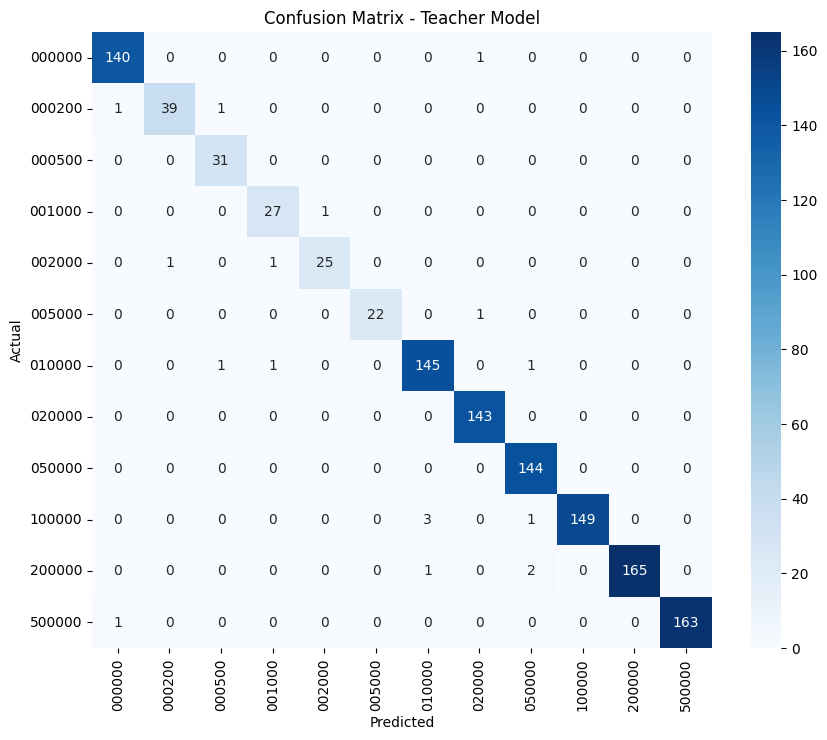

In [5]:
# Đào tạo mô hình giáo viên với các callback
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Định nghĩa các callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


# Huấn luyện mô hình giáo viên
history_teacher = teacher_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# In ra kết quả huấn luyện của mô hình giáo viên
plt.plot(history_teacher.history['accuracy'], label='train accuracy')
plt.plot(history_teacher.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Tính toán các chỉ số đánh giá trên tập kiểm tra
test_generator.reset()
predictions_teacher = teacher_model.predict(test_generator)
predictions_teacher = np.argmax(predictions_teacher, axis=1)

# In ra ma trận nhầm lẫn và các chỉ số đánh giá
print('Classification Report - Teacher Model:')
print(classification_report(test_generator.classes, predictions_teacher, target_names=categories.values()))

cm_teacher = confusion_matrix(test_generator.classes, predictions_teacher)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_teacher, annot=True, fmt='d', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Teacher Model')
plt.show()



In [ ]:
# In ra các giá trị loss và accuracy
print("Training Accuracy:", history_teacher.history['accuracy'])
print("Validation Accuracy:", history_teacher.history['val_accuracy'])
print("Training Loss:", history_teacher.history['loss'])
print("Validation Loss:", history_teacher.history['val_loss'])

# Vẽ đồ thị loss và accuracy
# Đồ thị loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_teacher.history['loss'], label='Training Loss')
plt.plot(history_teacher.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(history_teacher.history['accuracy'], label='Training Accuracy')
plt.plot(history_teacher.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()


In [6]:
# Lưu mô hình giáo viên vào Google Drive
teacher_model_path = '/content/drive/MyDrive/Colab Notebooks/VND/teacher1_model.h5'
teacher_model.save(teacher_model_path)


In [7]:
# Tải mô hình giáo viên
teacher_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/VND/teacher1_model.h5")
def build_student_model():
    model = Sequential()
    model.add(
        Conv2D(
            filters=32,
            kernel_size=3,
            activation="relu",
            padding="same",
            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(categories), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

student_model = build_student_model()
student_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,276 (512.80 KB)

 Trainable params: 130,316 (509.05 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Định nghĩa mô hình học sinh
def build_student_model():
    model = Sequential()
    model.add(
        Conv2D(
            filters=32,
            kernel_size=3,
            activation="relu",
            padding="same",
            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(categories), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

student_model = build_student_model()
student_model.summary()

# Thực hiện quá trình Distillation
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(self, optimizer, metrics, alpha=0.1, temperature=3):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.alpha = alpha
        self.temperature = temperature
        self.student_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.distillation_loss_fn = tf.keras.losses.KLDivergence()

    def train_step(self, data):
        x, y = data
        teacher_pred = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_pred = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_pred)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_pred / self.temperature, axis=1),
                tf.nn.softmax(student_pred / self.temperature, axis=1)
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_pred)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_pred = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_pred)

        self.compiled_metrics.update_state(y, student_pred)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, training=False):
        return self.student(inputs, training=training)

distilled_model = DistillationModel(student=student_model, teacher=teacher_model)

distilled_model.compile(
    optimizer="adam",
    metrics=["accuracy"],
    alpha=0.1,
    temperature=3,
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_28 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_29 (Ba  (None, 64, 64, 64)       

In [ ]:
# Định nghĩa các callback
early_stopping = EarlyStopping(monitor='val_student_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_student_loss', factor=0.2, patience=5, min_lr=0.0001)

# Huấn luyện mô hình học sinh
history_student = distilled_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Lưu mô hình học sinh vào Google Drive
student_model_path = '/content/drive/MyDrive/Colab Notebooks/VND/student1_model.h5'
student_model.save(student_model_path)

Epoch 1/100
227/227 [==============================] - 59s 248ms/step - accuracy: 0.4380 - student_loss: 1.7709 - distillation_loss: 0.0038 - val_accuracy: 0.3066 - val_student_loss: 2.1234 - lr: 0.0010
Epoch 2/100
227/227 [==============================] - 56s 248ms/step - accuracy: 0.6220 - student_loss: 1.0903 - distillation_loss: 0.0026 - val_accuracy: 0.3967 - val_student_loss: 1.8684 - lr: 0.0010
Epoch 3/100
227/227 [==============================] - 57s 250ms/step - accuracy: 0.7068 - student_loss: 0.8389 - distillation_loss: 0.0021 - val_accuracy: 0.2893 - val_student_loss: 6.1764 - lr: 0.0010
Epoch 4/100
227/227 [==============================] - 56s 249ms/step - accuracy: 0.7601 - student_loss: 0.7014 - distillation_loss: 0.0017 - val_accuracy: 0.3752 - val_student_loss: 2.3218 - lr: 0.0010
Epoch 5/100
227/227 [==============================] - 57s 251ms/step - accuracy: 0.8046 - student_loss: 0.5685 - distillation_loss: 0.0014 - val_accuracy: 0.6174 - val_student_loss: 1.647

Training Accuracy: [0.43795621395111084, 0.6219528913497925, 0.7067896723747253, 0.7600881457328796, 0.804572343826294, 0.8361107110977173, 0.8540145754814148, 0.8701280951499939, 0.8768764734268188, 0.8945049047470093, 0.9071753025054932, 0.9276959300041199, 0.9383004903793335, 0.9383004903793335, 0.9478033185005188, 0.9523481726646423, 0.9478033185005188, 0.9501445889472961, 0.956617534160614, 0.957030713558197, 0.9522104263305664, 0.9538630843162537, 0.9597851634025574, 0.9624018669128418, 0.9589588046073914, 0.9595097303390503, 0.9608869552612305, 0.9643299579620361, 0.9628150463104248, 0.964054524898529, 0.9661203622817993, 0.9650185704231262, 0.9647431373596191, 0.9654317498207092, 0.963779091835022, 0.9676353335380554]
Validation Accuracy: [0.306611567735672, 0.39669421315193176, 0.28925618529319763, 0.3752066195011139, 0.6173553466796875, 0.7363636493682861, 0.06280991435050964, 0.45041322708129883, 0.6181818246841431, 0.35206612944602966, 0.6611570119857788, 0.6694214940071106

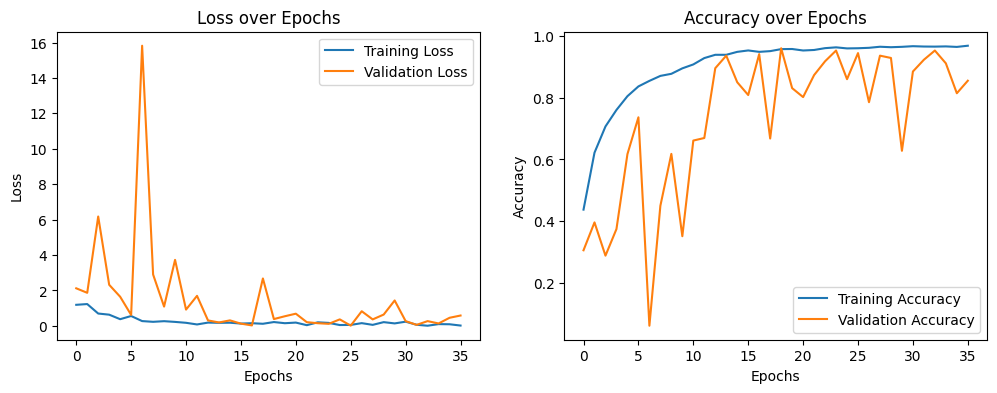

In [ ]:
import matplotlib.pyplot as plt

# In ra các giá trị loss và accuracy
print("Training Accuracy:", history_student.history['accuracy'])
print("Validation Accuracy:", history_student.history['val_accuracy'])
print("Training Loss:", history_student.history['student_loss'])
print("Validation Loss:", history_student.history['val_student_loss'])

# Vẽ đồ thị loss và accuracy
# Đồ thị loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_student.history['student_loss'], label='Training Loss')
plt.plot(history_student.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(history_student.history['accuracy'], label='Training Accuracy')
plt.plot(history_student.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()


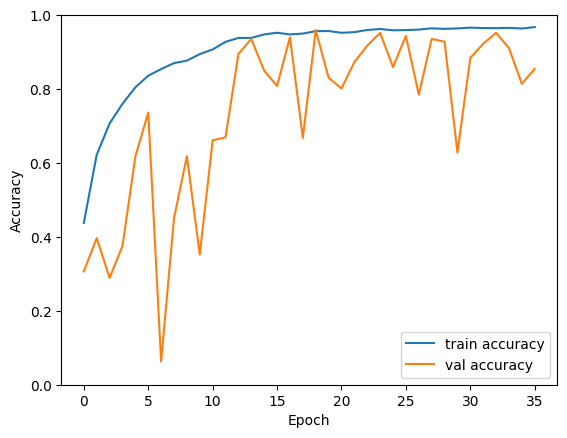

1211/1211 [==============================] - 9s 7ms/step
Classification Report - Student Model:
              precision    recall  f1-score   support

      000000       1.00      0.90      0.95       135
      000200       0.82      0.94      0.88        34
      000500       1.00      0.89      0.94        28
      001000       0.74      0.97      0.84        32
      002000       0.83      0.81      0.82        42
      005000       0.93      1.00      0.96        26
      010000       0.94      0.97      0.96       151
      020000       0.96      0.95      0.96       148
      050000       0.90      0.96      0.93       168
      100000       0.97      0.98      0.97       143
      200000       0.97      0.87      0.92       157
      500000       0.95      0.95      0.95       147

    accuracy                           0.94      1211
   macro avg       0.92      0.93      0.92      1211
weighted avg       0.94      0.94      0.94      1211



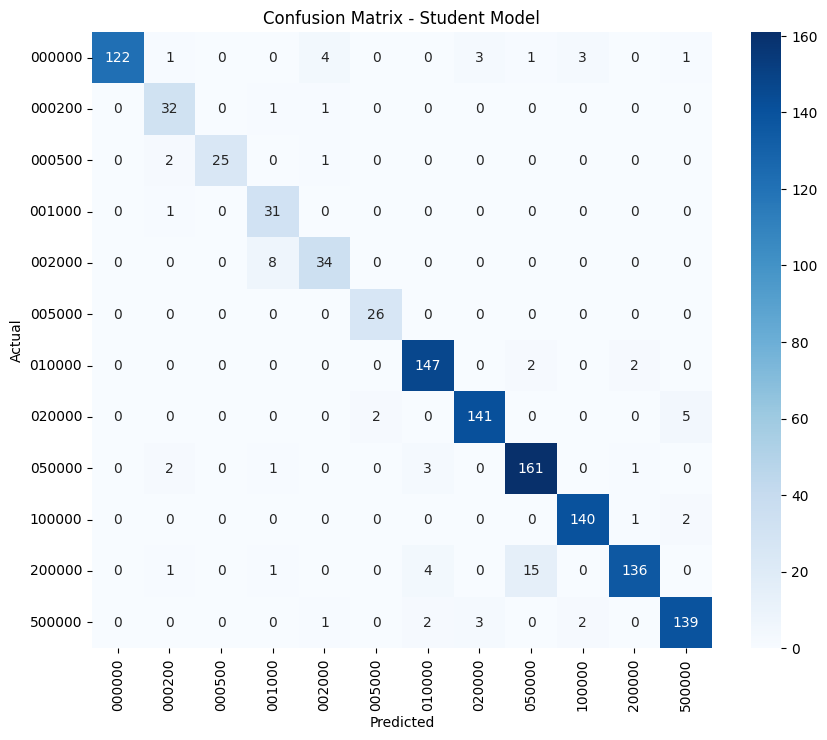

In [ ]:
# In ra kết quả huấn luyện của mô hình học sinh
plt.plot(history_student.history['accuracy'], label='train accuracy')
plt.plot(history_student.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Tính toán các chỉ số đánh giá trên tập kiểm tra
test_generator.reset()
predictions_student = student_model.predict(test_generator)
predictions_student = np.argmax(predictions_student, axis=1)

# In ra ma trận nhầm lẫn và các chỉ số đánh giá
print('Classification Report - Student Model:')
print(classification_report(test_generator.classes, predictions_student, target_names=categories.values()))

cm_student = confusion_matrix(test_generator.classes, predictions_student)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_student, annot=True, fmt='d', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Student Model')
plt.show()


Thử nhận dạng

In [ ]:
# Thử nghiệm mô hình
student_model_path = '/content/drive/MyDrive/Colab Notebooks/VND/student1_model.h5'
student_model = tf.keras.models.load_model(student_model_path)
input_data = load_and_preprocess_image('/content/gdrive/MyDrive/Colab Notebooks/VND/50k.1.jpg')

# Dự đoán với mô hình không quantized
predictions = student_model.predict(input_data)
predicted_class = np.argmax(predictions)
predicted_label = categories[predicted_class]
print(f"Predicted label with original model: {predicted_label}")


In [ ]:
import tensorflow as tf

# Tải mô hình học sinh từ Google Drive
student_model_path = '/content/drive/MyDrive/Colab Notebooks/VND/student1_model.h5'
student_model = tf.keras.models.load_model(student_model_path)

# Chuyển đổi mô hình sang định dạng TensorFlow Lite mà không áp dụng quantization
converter = tf.lite.TFLiteConverter.from_keras_model(student_model)
tflite_model = converter.convert()

# Lưu mô hình TensorFlow Lite
tflite_model_path = '/content/drive/MyDrive/Colab Notebooks/VND/student1_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Tải mô hình TensorFlow Lite và phân bổ tensor
interpreter = tf.lite.Interpreter(model_path='path_to_your_model/student_model.tflite')
interpreter.allocate_tensors()

# Lấy thông tin về các tensor đầu vào và đầu ra
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Hàm để tải và tiền xử lý ảnh đầu vào
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))  # Resize để khớp với kích thước đầu vào của mô hình
    img = np.array(img, dtype=np.float32)
    img = img / 255.0  # Chuẩn hóa ảnh (nếu cần)
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension
    return img

image_path = 'path_to_your_image/image.jpg'
input_data = load_and_preprocess_image(image_path)

# Đặt tensor đầu vào để chỉ đến dữ liệu đầu vào cần dự đoán
interpreter.set_tensor(input_details[0]['index'], input_data)

# Chạy suy luận
interpreter.invoke()

# Trích xuất dữ liệu đầu ra
output_data = interpreter.get_tensor(output_details[0]['index'])

# In ra dữ liệu đầu ra
print("Output predictions:", output_data)

# Giả sử categories là dictionary ánh xạ từ các chỉ số lớp đến tên nhãn
categories = {
    0: "000000",
    1: "000200",
    2: "000500",
    3: "001000",
    4: "002000",
    5: "005000",
    6: "010000",
    7: "020000",
    8: "050000",
    9: "100000",
    10: "200000",
    11: "500000",
}

# Lấy chỉ số của dự đoán có xác suất cao nhất
predicted_class = np.argmax(output_data)

# Tìm nhãn tương ứng
predicted_label = categories[predicted_class]
print(f"Predicted label: {predicted_label}")
